<h1>Code Modules & Functions</h1>

In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-epe8d_9m
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-epe8d_9m
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.04c42ce20a2fbc4b0aad83bfa86ba776b05826847_-py3-none-any.whl size=119800 sha256=18d0116da7e10cbcf56facac26d47fcbd8a72f8ea55c250f2cd571e053a5c8cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-u7e8idmx/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,tensorflow as tf
import h5py,imageio,os,torch
import seaborn as sn,pylab as pl
from keras.preprocessing import image as kimage
from tensorflow_docs.vis import embed
from tqdm import tqdm
from PIL import ImageFile,Image
ImageFile.LOAD_TRUNCATED_IMAGES=True
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
from IPython.core.magic import register_line_magic

Using TensorFlow backend.


In [3]:
def path_to_tensor(img_path,fpath):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(160,160))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath):
    tensor_list=[path_to_tensor(img_path,fpath) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
def animate(images):
    converted_images=np.clip(images*255,0,255)\
    .astype(np.uint8)
    imageio.mimsave('animation.gif',converted_images)
    return embed.embed_file('animation.gif')
def interpolate_hypersphere(v1,v2,steps):
    v1norm=tf.norm(v1)
    v2norm=tf.norm(v2)
    v2normalized=v2*(v1norm/v2norm)
    vectors=[]
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-1)
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=\
        interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)
def plcmap(cmap,n):
    return [pl.cm.get_cmap(cmap)(i/n)[:3] 
            for i in range(1,n+1)]

<h1>Ways of Data Processing</h1>

In [4]:
fpath='../input/horse-breeds/'
names=['Akhal-Teke','Appaloosa','Orlov Trotter',
       'Vladimir Heavy Draft']
flist=sorted(os.listdir(fpath))
labels=np.array([int(el[:2]) for el in flist],
               dtype='int8')-1
images=np.array(paths_to_tensor(flist,fpath=fpath),
                dtype='float32')/255
N=labels.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_train=images[:n],images[n:]
y_test,y_train=labels[:n],labels[n:]

100%|██████████| 108/108 [00:01<00:00, 97.69it/s] 


In [5]:
pd.DataFrame([[x_train.shape,x_test.shape],
              [x_train.dtype,x_test.dtype],
              [y_train.shape,y_test.shape],
              [y_train.dtype,y_test.dtype]],               
             columns=['train','test'])

train               test
0  (87, 160, 160, 3)  (21, 160, 160, 3)
1            float32            float32
2              (87,)              (21,)
3               int8               int8

In [6]:
with h5py.File('HorseBreedImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train)
    f.create_dataset('train_labels',data=y_train)
    f.create_dataset('test_images',data=x_test)
    f.create_dataset('test_labels',data=y_test)
os.stat('HorseBreedImages.h5')

os.stat_result(st_mode=33188, st_ino=131083, st_dev=1793, st_nlink=1, st_uid=0, st_gid=0, st_size=33181804, st_atime=1594140703, st_mtime=1594140703, st_ctime=1594140703)

In [7]:
train_csv='train.csv'; test_csv='test.csv'
img_path='../input'
files=[os.path.relpath(os.path.join(dirpath,fn),img_path) \
for (dirpath,dirnames,filenames) in os.walk(img_path) \
for fn in filenames if fn.endswith('.png')]
d={'label':[],'breed':[],'file':[],'path':[]}
for f in files:
    _,fn=f.split('/')
    label=int(fn[:2])-1
    breed=names[label]        
    d['label'].append(label)
    d['breed'].append(breed)
    d['file'].append(fn)
    d['path'].append(f)
df=pd.DataFrame.from_dict(d)
np.random.seed(123)
ids=np.random.rand(len(df))<.8
df_train=df[ids]; df_test=df[~ids]
df_train.set_index('file',inplace=True)
df_train.to_csv(train_csv)
df_test.set_index('file',inplace=True)
df_test.to_csv(test_csv)
num_classes=np.unique(df['label'].values).shape[0]
print([num_classes,len(files)]); df.head()

[4, 108]


label                 breed        file                     path
0      1             Appaloosa  02_008.png  horse-breeds/02_008.png
1      3  Vladimir Heavy Draft  04_020.png  horse-breeds/04_020.png
2      1             Appaloosa  02_017.png  horse-breeds/02_017.png
3      1             Appaloosa  02_003.png  horse-breeds/02_003.png
4      0            Akhal-Teke  01_009.png  horse-breeds/01_009.png

In [8]:
class HorseBreedsData(tds):
    def __init__(self,csv_path,img_dir,transform=None):
        df=pd.read_csv(csv_path,index_col=0)
        self.img_dir=img_dir
        self.csv_path=csv_path
        self.img_paths=df['path']
        self.y=df['label'].values
        self.transform=transform
    def __getitem__(self,index):
        img=Image.open(os.path\
        .join(self.img_dir,self.img_paths[index]))
        if self.transform is not None:
            img=self.transform(img)
        lbl=self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [9]:
batch_size=12; num_workers=4
grayscale=False; img_size=128
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor()])
train=HorseBreedsData(csv_path=train_csv,
                      img_dir=img_path,
                      transform=trans)
test=HorseBreedsData(csv_path=test_csv,
                     img_dir=img_path,
                     transform=trans)
dataloaders={'train':tdl(dataset=train,batch_size=batch_size,
                         shuffle=True,num_workers=num_workers),
             'test':tdl(dataset=test,batch_size=batch_size,
                        shuffle=True,num_workers=num_workers)}

<h1>Data Representation</h1>

In [10]:
set(labels)

{0, 1, 2, 3}

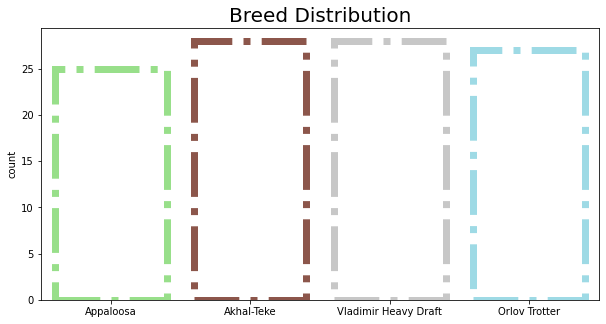

In [11]:
pl.figure(figsize=(10,5))
sn.countplot(x=[names[x] for x in labels],
             facecolor=(0,0,0,0),
             linewidth=7,linestyle='-.',
             edgecolor=plcmap('tab20',4))
pl.title('Breed Distribution',fontsize=20);

Label:  0 Akhal-Teke


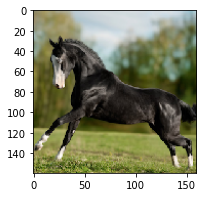

In [12]:
n=np.random.randint(5)
print('Label: ',y_test[n],
      names[y_test[n]])
pl.figure(figsize=(3,3))
pl.imshow((x_test[n]));

In [13]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,5)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=names[labels[i].item()])
            ax.imshow(np.transpose(images[i],(1,2,0)))
        break

Image dimensions: torch.Size([12, 4, 128, 128])
Label dimensions: torch.Size([12])


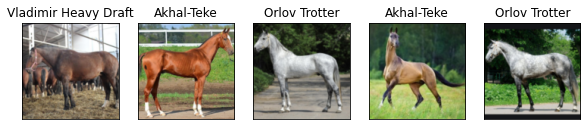

In [14]:
%display_examples test


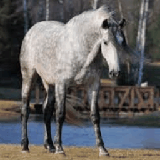

In [15]:
imgs=interpolate_hypersphere(x_train[0],x_train[1],240)
animate(imgs)